# 最終発表

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import plot_error_KF, estimate_error_with_params
from localization import plot_gaspari_cohn


# 内容
- 自己紹介
    - 所属
- 振り返り
    - 今回の目的
    - 学んだこと
- 進捗
    - LETKF8で精度を出す．
    - gaspari cohn
- KFの比較
    - 実行時間とrmse
- これから
    - addaptive inflation
    - 並列化

# 自己紹介
竹田航太

所属: 京都大学 大学院理学研究科 数学教室 坂上研究室

学年: 1年

専攻: 応用数学

興味: 流体，UQ(Uncertainty Quantification)， データ同化，機械学習，気象予報

# 進捗

## Gaspari Cohn
### gaspari cohn vs gaussian
パラメータの対応関係．以下の対応がある．

$ G_c(x, c) \leftrightarrow \exp(- \frac{x^2}{2L^2}) $

ただし，$ L = c(0.3)^{1/2} $

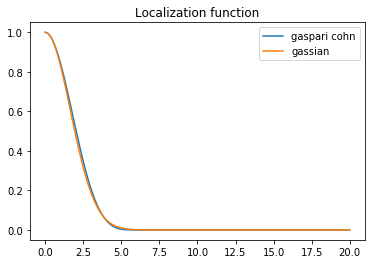

In [3]:
c = 3
L = c*(0.3)**(1/2)
plot_gaspari_cohn(c)
x_arr = np.linspace(0, 20, 100)
y_func = [np.exp(-x**2/(2*L**2)) for x in x_arr]
plt.plot(x_arr, y_func, label='gassian')
plt.legend()

## LETKF

### アルゴリズム
$ \tilde{P^a} = [(N-1)I/\rho + dY^T R^{-1} dY]^{-1} $

$ T = \tilde{P^a} dY^T R^{-1}(y^o - \overline{dY^f}) + [(N-1) \tilde{P^a}]^{1/2} $

$ X^a = x^f + dX^f T$

iteration:
- 各観測で状態変数の数N=40回
- 各i(in 1~40)で
    - x_iを推定．
    - x_iに近い観測を用いる．-> localization
    
localization:
- R-locで実装．R-inverseにlocal functionをかける．
- local functionとしてgaspari cohn functionを採用．

Text(69.0, 0.5, 'alpha')

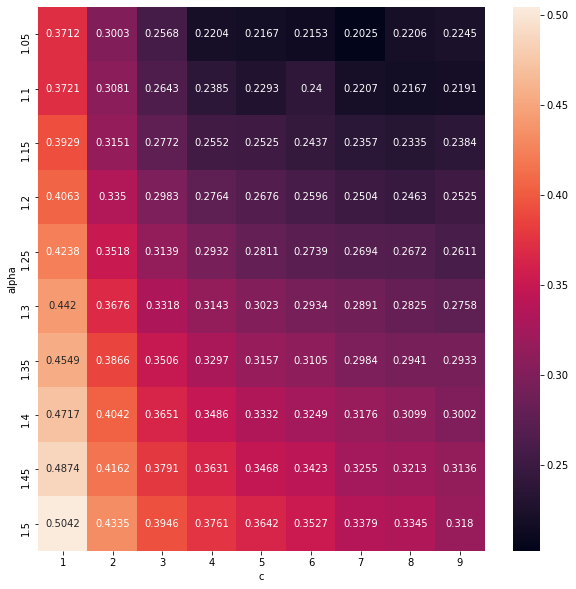

In [17]:
df = pd.read_csv('data/letkf/letkf_alpha_c_rough.csv', index_col=0, header=0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.iloc[1:, :9], annot=True, fmt='.4g')
ax.set_xlabel('c')
ax.set_ylabel('alpha')

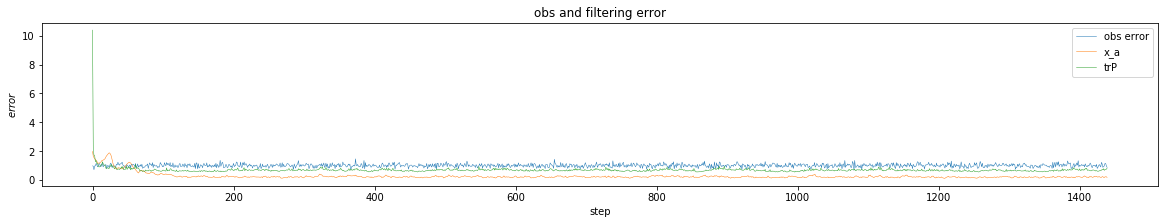

rmse: 0.2037757543072912


In [32]:
# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

x, trP = np.load('data/letkf/letkf_optimal.npy', allow_pickle=True)

plot_error_KF(true, y, [x], trPs=[trP], legends=['x_a', 'x_f'])
_, _, rmse = estimate_error_with_params(true, [x], [8], 'm', plot=False)
print('rmse: {}'.format(rmse))

## KFの比較
実行時間とRMSE


### 設定
- 全点観測
- 1年分(360*4 step)のうち，200 stepをspin up
- RMSEの時間平均を比べる．

Text(0.5, 1.0, 'RMSE vs time')

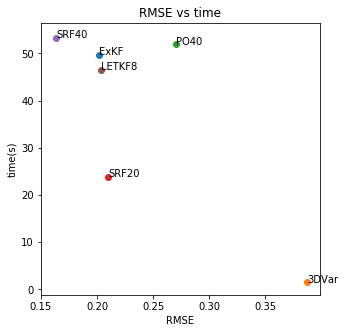

In [15]:
# TODO:整理し直す．
labels = np.array(['ExKF', '3DVar', 'PO40', 'SRF20', 'SRF40', 'SRF50', 'LETKF8']) # LETKF8, LETKF40追加
rmses = np.array([0.2018, 0.3871, 0.2705, 0.2099, 0.1636, 0.1679, 0.2037])
times = np.array([49.6, 1.49, 51.9, 23.9, 53.2, 122, 46.5])
fig, ax = plt.subplots(figsize=(5,5))
index = [0,1,2,3,4,6]
for i in range(len(labels[index])):
    idx = index[i]
    ax.scatter(rmses[idx], times[idx])
    ax.text(rmses[idx], times[idx], labels[idx])

ax.set_xlabel('RMSE')
ax.set_ylabel('time(s)')
plt.title('RMSE vs time')

# scores = [1/x for x in rmses**3*times**0.5]
# fig1, ax1 = plt.subplots()
# ax1.bar(range(len(labels)), scores, tick_label=labels)
# plt.title('score')

## 課題
- LETKFの実行速度が遅い．
- LETKFの精度が悪い．

## これから
- addaptive inflation
- 並列化

# 振り返り

## 今回の目的
- データ同化の実践的理論の学習．
- 大自由度系の数値計算に関する知識の獲得．
- Kalman Filterの実装．

## 学んだこと
- データ同化に関して
    - データ同化の理論についての復習．
    - 大規模自由度系での計算についての実践的知識．
    - additive inflationをしない理由がわかった．
- 細かい実装
    - 行列計算では言語やライブラリの仕様に気をつける．
        - ExKFの線形化コード
        - アンサンブルの表現
        - LETKFのTransform
- 他の人との関わり
    - 他の人の発表方法は参考になる．
    - 他の人が書いたコードを見るのも勉強になる．
- その他
    - 可視化の重要性